# Velocity model-obs(ADCP) comparison

In [9]:
import subprocess
import os
import pandas as pd
import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
import seawater as sw
from roms_regrid import *

In [10]:
HAFRO_path='/home/x-uheede/R/HAFRO/Hafro_cruises.xls'
model_grid_path="/home/x-uheede/S/Iceland2_MARBL_2024_60m/P_INPUT/Iceland2_grid_MAT1.nc"
# Grid parameters, only modify these if grid is made in MATLAB
vert_levels=60
theta_s_model=5
theta_b_model=2
hc_model=300
model_data_path="/home/x-uheede/S/Iceland2_NOMARBL_2024_RHALF/Iceland2_MARBL_2024_his.20240[4]????????.nc"
months_analysis=[4] # enter the months you want to analyze for the model
# enter the dates you want to analyze for the observations
target_depth_levels=[10] # Specify depth levels of interest
thinner=1 # specify the temporal frequency of data being read (i.e. no need to read in hourly data)


In [11]:
from roms_tools import Grid, ROMSOutput
grid = Grid.from_file(
    model_grid_path
)


2025-12-08 14:37:30 - WARNING - Vertical coordinates (Cs_r, Cs_w) not found in grid file.
2025-12-08 14:37:30 - INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
2025-12-08 14:37:30 - INFO - Total time: 0.003 seconds
2025-12-08 14:37:30 - INFO - ========================================================================================================


In [12]:
#Only run this cell if grid is made in MATLAB
grid.update_vertical_coordinate(N=vert_levels, theta_s=theta_s_model, theta_b=theta_b_model, hc=hc_model, verbose=False)

In [13]:


# Define file paths and station names
stations = ["HVIN_1", "HVNA_1", "HVNV_1", "HVSA_1", "HVSV_1"]
file_paths = {name: f"/home/x-uheede/R/HAFRO/{name}new.nc" for name in stations}

# Dictionary to store datasets
datasets = {}

for name, path in file_paths.items():
    ds = xr.open_dataset(path)

    # Select valid depth bins
    good_bins = ds['iigood'].where(ds['iigood'] < 20).to_numpy()
    good_bins_nn = good_bins[~np.isnan(good_bins)].astype(int)
    
    ds = ds.isel(depth_dim=slice(np.min(good_bins_nn), np.max(good_bins_nn)))

    # Store dataset with adjusted longitude
    datasets[name] = ds.assign_coords(lon=ds['lon'].load() + 360)



In [14]:


subtract = 739674 - 9189  # Computed constant
reference_date = pd.to_datetime("2000-01-01")  # Reference date

# Apply transformation to all datasets
for name, ds in datasets.items():
    datetime_series = reference_date + pd.to_timedelta((ds['time'].values - subtract), unit='D')
    datasets[name] = ds.assign_coords(time_dim=datetime_series)  # Update the time coordinate


In [15]:
from roms_tools import Grid, ROMSOutput

In [16]:
import xarray as xr
import numpy as np

# Load ROMS output using your pattern
roms_output = ROMSOutput(
    grid=grid,
    path=[
        model_data_path,
    ],
    use_dask=True,
)

ds = roms_output.regrid(var_names=["u", "v"],depth_levels=target_depth_levels)

In [17]:
u_rg=ds['u'].load()
v_rg=ds['v'].load()

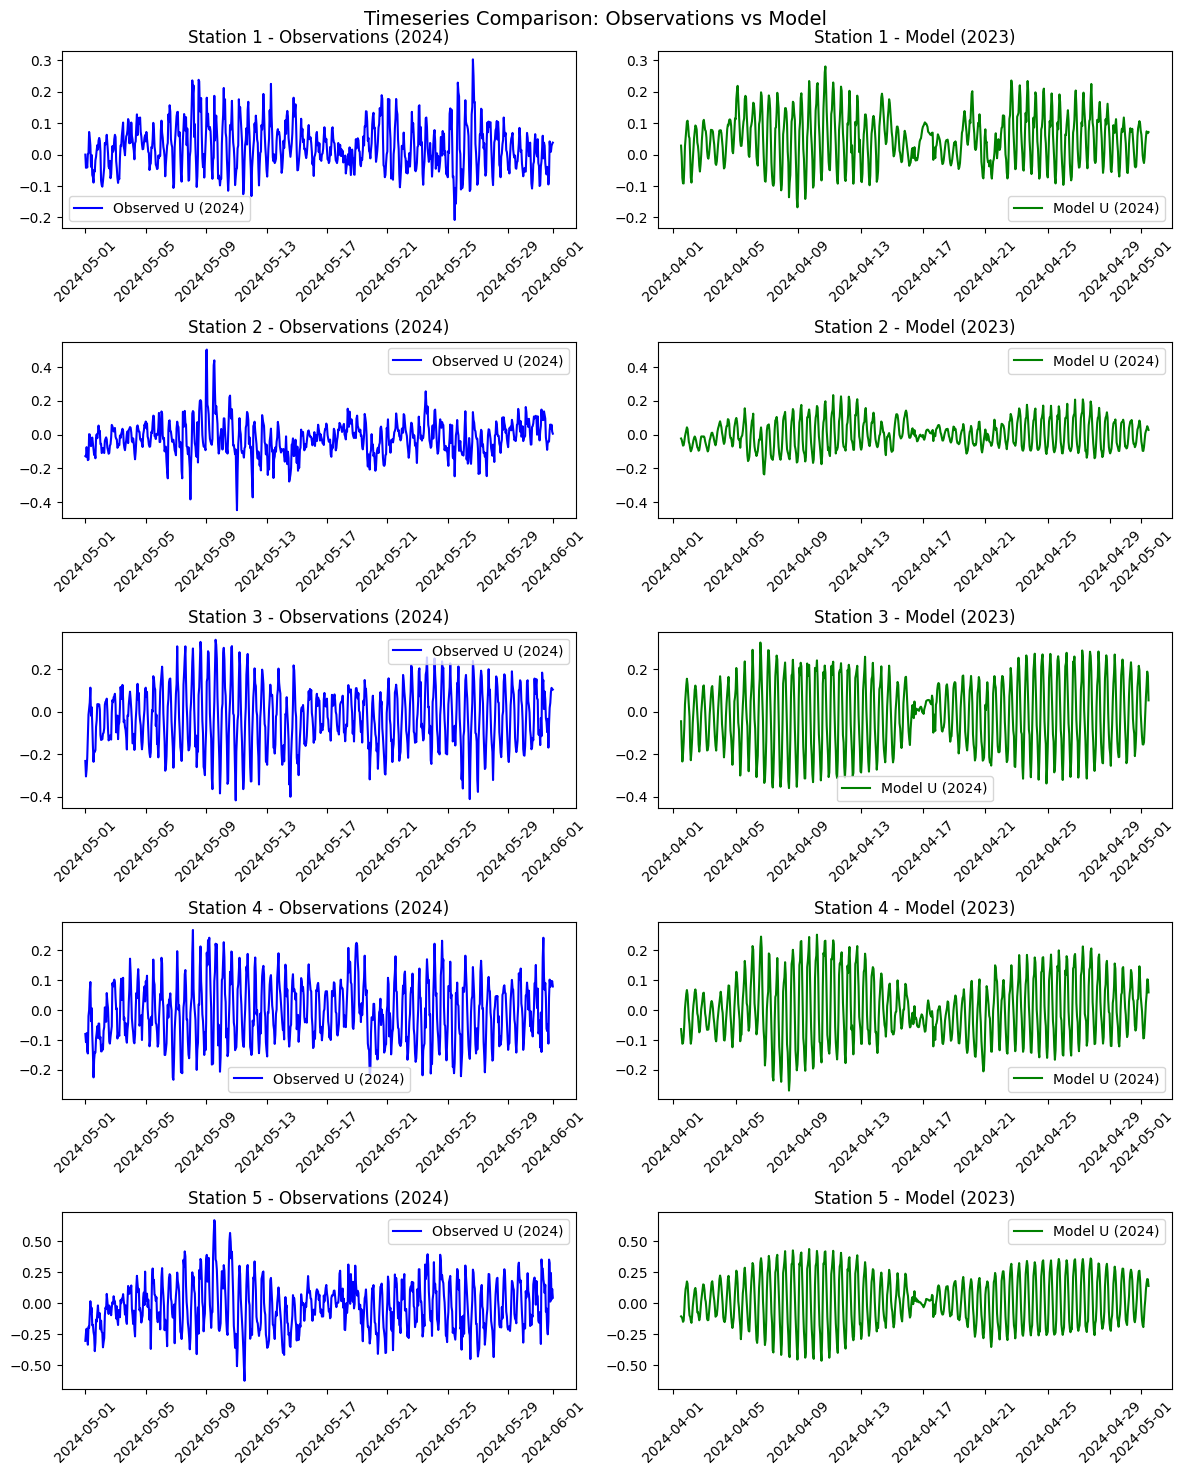

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from windrose import WindroseAxes

# Define the number of stations
num_stations = 5

# Define the observation subset time range (2024)
obs_time_range = slice('2024-05-01', '2024-05-31')

# Define the model subset time range (2023)
model_time_range = slice('2024-02-01', '2024-02-28')

# Create figure for timeseries plots
fig, axs = plt.subplots(
    nrows=num_stations, ncols=2, figsize=(12, 3 * num_stations), sharex=False
)
fig.suptitle("Timeseries Comparison: Observations vs Model", fontsize=14)

for i in range(num_stations):

    # Subset observation data for 2024
    obs = list(datasets.values())[i]
    obs_subset = obs.sel(time_dim=obs_time_range)
    depth_index = (np.abs(obs_subset['depth_dim'].values - 10)).argmin()
    u_obs = obs_subset['u'].isel(depth_dim=depth_index)[::6]
    obs_lon = obs.lon
    obs_lat = obs.lat

    # Extract model data
    u_sel = u_rg.sel(lon=obs_lon.values, method='nearest').sel(lat=obs_lat.values, method='nearest')
    u_mod = u_sel.squeeze()

    # ----------------------------
    # Compute shared y-limits
    # ----------------------------
    ymin = min(u_obs.min().item(), u_mod.min().item())
    ymax = max(u_obs.max().item(), u_mod.max().item())

    # Add small padding
    yrange = ymax - ymin
    ymin -= 0.05 * yrange
    ymax += 0.05 * yrange

    # Plot observations (2024)
    axs[i, 0].plot(obs_subset.time_dim[::6], u_obs, label="Observed U (2024)", color="blue")
    axs[i, 0].set_title(f"Station {i+1} - Observations (2024)")
    axs[i, 0].tick_params(axis='x', rotation=45)
    axs[i, 0].set_ylim([ymin, ymax])
    axs[i, 0].legend()

    # Plot model (2023)
    axs[i, 1].plot(u_rg['time'], u_mod, label="Model U (2024)", color="green")
    axs[i, 1].set_title(f"Station {i+1} - Model (2023)")
    axs[i, 1].tick_params(axis='x', rotation=45)
    axs[i, 1].set_ylim([ymin, ymax])
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


In [19]:
obs.lat

<xarray.DataArray 'lat' (lat_dim: 1)> Size: 8B
array([64.299167])
Dimensions without coordinates: lat_dim

/home/x-uheede/.conda/envs/2024.02-py311/roms-tools/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


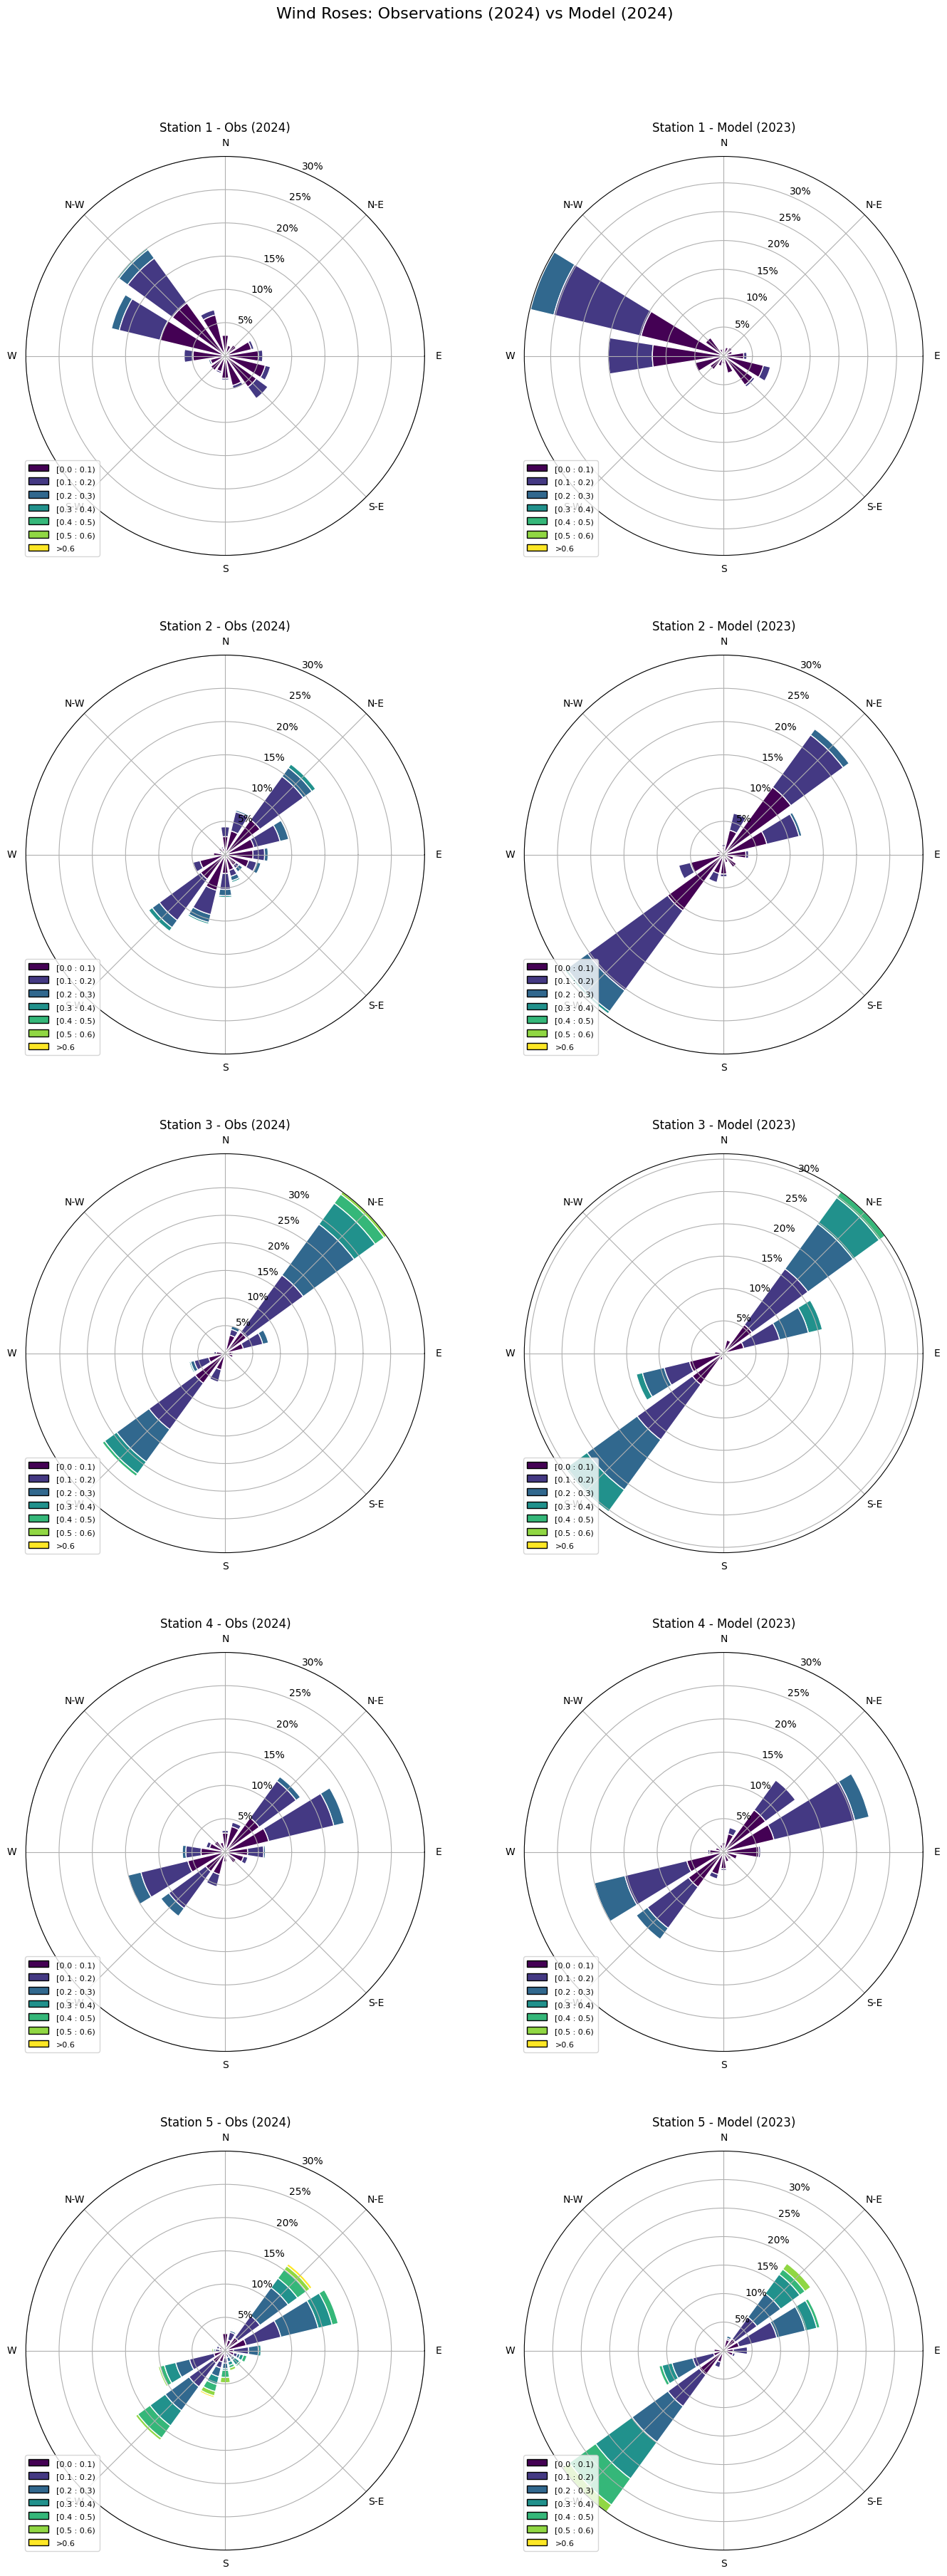

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Define number of stations
num_stations = 5

# Create a figure with 2 columns (Obs & Model) and num_stations rows
fig = plt.figure(figsize=(14, 7 * num_stations),layout='tight')

fig.suptitle("Wind Roses: Observations (2024) vs Model (2024)", fontsize=16)

for i in range(num_stations):

    # Compute observed wind speed and direction
    obs=list(datasets.values())[i]
    obs_subset = obs.sel(time_dim=obs_time_range)
    depth_index = (np.abs(obs_subset['depth_dim'].values - 10)).argmin()
    u_obs = obs_subset['u'].sel(depth_dim=depth_index)[::6]
    v_obs = obs_subset['v'].sel(depth_dim=depth_index)[::6]
    obs_lon=obs.lon
    obs_lat=obs.lat
    direction_obs = (np.arctan2(-u_obs.squeeze().values, -v_obs.squeeze().values) * (180 / np.pi) + 360) % 360
    speed_obs = np.sqrt(u_obs.squeeze().values**2 + v_obs.squeeze().values**2)

    # Compute model wind speed and direction
    u_sel = u_rg.sel(lon=obs_lon.values, method='nearest').sel(lat=obs_lat.values, method='nearest')
    v_sel = v_rg.sel(lon=obs_lon.values, method='nearest').sel(lat=obs_lat.values, method='nearest')
    
    direction_model = (np.arctan2(-u_sel.squeeze().values, -v_sel.squeeze().values) * (180 / np.pi) + 360) % 360
    speed_model = np.sqrt(u_sel.squeeze().values**2 + v_sel.squeeze().values**2)

    # Define subplot positions using bbox (left, bottom, width, height)
    ax_obs = WindroseAxes(fig, [0.05, 0.75 - (i * 0.2), 0.4, 0.18])  # Left column
    fig.add_axes(ax_obs)
    ax_obs.bar(direction_obs, speed_obs, normed=True, opening=0.8, edgecolor='white', bins=np.linspace(0, 0.6, 7))
    ax_obs.set_title(f"Station {i+1} - Obs (2024)", fontsize=12)
    ax_obs.set_legend()
    ax_obs.set_rticks([5, 10, 15, 20, 25, 30])
    ax_obs.set_yticklabels(['5%', '10%', '15%', '20%', '25%', '30%'])
    
    ax_model = WindroseAxes(fig, [0.55, 0.75 - (i * 0.2), 0.4, 0.18])  # Right column
    fig.add_axes(ax_model)
    ax_model.bar(direction_model, speed_model, normed=True, opening=0.8, edgecolor='white', bins=np.linspace(0, 0.6, 7))
    ax_model.set_title(f"Station {i+1} - Model (2023)", fontsize=12)
    ax_model.set_legend()
    ax_model.set_rticks([5, 10, 15, 20, 25, 30])
    ax_model.set_yticklabels(['5%', '10%', '15%', '20%', '25%', '30%'])

plt.show()


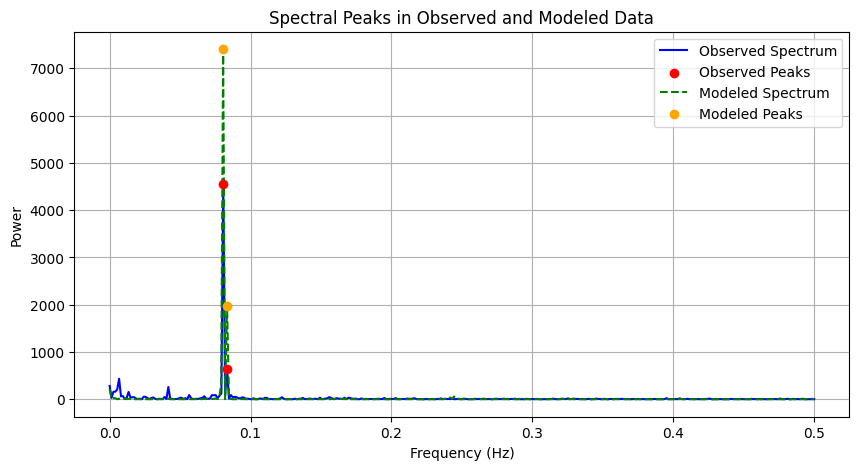

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def compute_spectrum(time, signal):
    """Compute the FFT and identify spectral peaks."""
    
    # Compute FFT
    n = len(signal)
    dt = np.mean(np.diff(time))  # Time step (assuming uniform spacing)
    freq = np.fft.rfftfreq(n, d=dt)  # Compute frequency axis
    spectrum = np.fft.rfft(signal)   # Compute FFT
    power = np.abs(spectrum)**2      # Compute Power Spectral Density (PSD)
    
    # Find peaks in the power spectrum
    peaks, _ = find_peaks(power, height=np.max(power) * 0.1)  # Peaks with at least 10% of max power
    
    return freq, power, peaks
reference_time = np.datetime64('2000-01-01T00:00:00', 's')

# Example time series (Replace these with your observed and modeled data)
obs_time = (obs_subset.time_dim[::6].load() - reference_time).astype('timedelta64[h]').astype(int).load().values
# Define reference time (2000-01-01T00:00:00)



model_time = (u_rg['time'].load() - reference_time).astype('timedelta64[h]').astype(int).load().values# Example time axis (modify as needed)
obs_time=(obs_time-obs_time[0])*10**(-0)*1/3600
model_time=(model_time-model_time[0])*10**(-0)*1/3600

observed_signal = u_obs.squeeze().values  # Example signal
modeled_signal = u_sel.squeeze().values # Example signal

# Compute spectra
freq_obs, power_obs, peaks_obs = compute_spectrum(obs_time, observed_signal)
freq_mod, power_mod, peaks_mod = compute_spectrum(model_time, modeled_signal)

# Plot results
plt.figure(figsize=(10, 5))

# Observed Spectrum
plt.plot(freq_obs, power_obs, label="Observed Spectrum", color='b')
plt.scatter(freq_obs[peaks_obs], power_obs[peaks_obs], color='r', label="Observed Peaks", zorder=3)

# Modeled Spectrum
plt.plot(freq_mod, power_mod, label="Modeled Spectrum", color='g', linestyle='dashed')
plt.scatter(freq_mod[peaks_mod], power_mod[peaks_mod], color='orange', label="Modeled Peaks", zorder=3)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.title("Spectral Peaks in Observed and Modeled Data")
plt.grid()
plt.show()



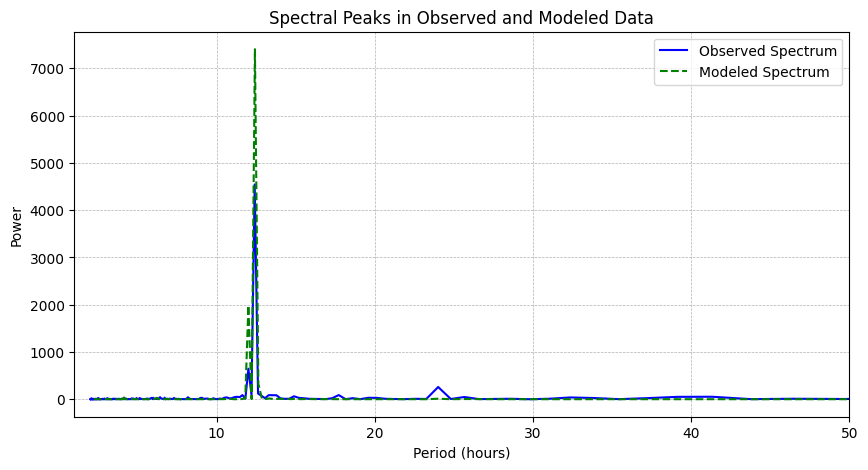

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Convert frequency to period (avoid division by zero)
period_obs = 1 / freq_obs[1:]  # Ignore first value to avoid division by zero
period_mod = 1 / freq_mod[1:]

# Plot results
plt.figure(figsize=(10, 5))

# Observed Spectrum
plt.plot(period_obs, power_obs[1:], label="Observed Spectrum", color='b')
#plt.scatter(period_obs[peaks_obs - 1], power_obs[peaks_obs][1:], color='r', label="Observed Peaks", zorder=3)

# Modeled Spectrum
plt.plot(period_mod, power_mod[1:], label="Modeled Spectrum", color='g', linestyle='dashed')
#plt.scatter(period_mod[peaks_mod - 1], power_mod[peaks_mod][1:], color='orange', label="Modeled Peaks", zorder=3)

#plt.xscale("log")  # Log scale to better show long periods
plt.xlabel("Period (hours)")
plt.ylabel("Power")
plt.legend()
plt.title("Spectral Peaks in Observed and Modeled Data")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.gca().invert_xaxis()  # Invert x-axis so long periods are on the right
plt.xlim(1,50)
plt.show()


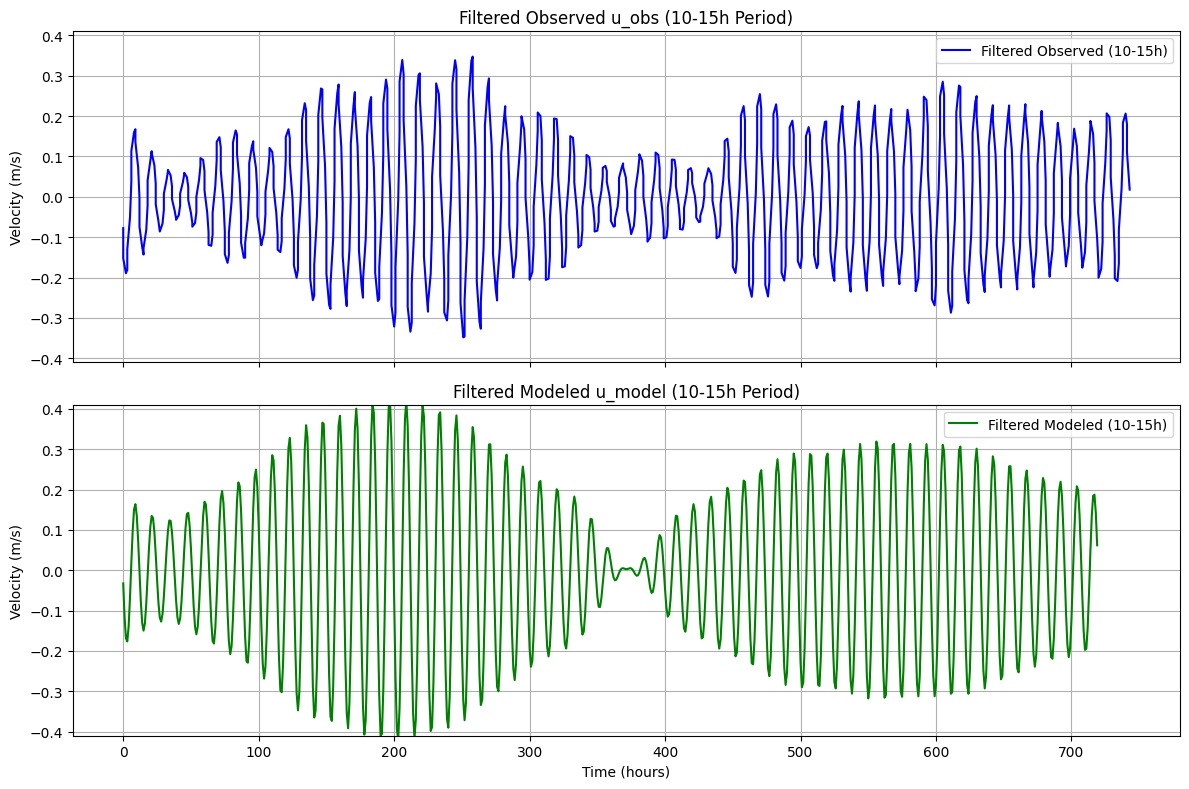

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def bandpass_filter(time, signal, min_period=10, max_period=15):
    """Filter the signal to retain only frequencies corresponding to periods between min_period and max_period hours."""
    
    # Compute FFT
    n = len(signal)
    dt = np.mean(np.diff(time))  # Time step in hours
    freq = np.fft.rfftfreq(n, d=dt)  # Frequency axis (in Hz or cycles per hour)
    spectrum = np.fft.rfft(signal)   # Compute FFT

    # Convert periods to frequencies
    min_freq = 1 / max_period  # Lower cutoff frequency
    max_freq = 1 / min_period  # Upper cutoff frequency

    # Zero out frequencies outside the band
    spectrum[(freq < min_freq) | (freq > max_freq)] = 0

    # Inverse FFT to reconstruct filtered signal
    filtered_signal = np.fft.irfft(spectrum, n=n)

    return filtered_signal

# Convert time to hours since reference time
reference_time = np.datetime64('2000-01-01T00:00:00', 's')
obs_time = (obs_subset.time_dim[::6].load() - reference_time).astype('timedelta64[h]').astype(int).values
model_time = (u_rg['time'] - reference_time).astype('timedelta64[h]').astype(int).load().values
obs_time=(obs_time-obs_time[0])*10**(-0)*1/3600
model_time=(model_time-model_time[0])*10**(-0)*1/3600

# Apply band-pass filter
u_obs_filtered = bandpass_filter(obs_time, u_obs.squeeze().values, min_period=10, max_period=15)
u_model_filtered = bandpass_filter(model_time, u_sel.squeeze().values, min_period=10, max_period=15)

# Create figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot filtered observed signal
axs[0].plot(obs_time, u_obs_filtered, label="Filtered Observed (10-15h)", color='b')
axs[0].set_ylabel("Velocity (m/s)")
axs[0].set_ylim(-.41,.41)
axs[0].set_title("Filtered Observed u_obs (10-15h Period)")
axs[0].legend()
axs[0].grid()

# Plot filtered modeled signal
axs[1].plot(model_time, u_model_filtered, label="Filtered Modeled (10-15h)", color='g')
axs[1].set_xlabel("Time (hours)")
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_ylim(-.41,.41)
axs[1].set_title("Filtered Modeled u_model (10-15h Period)")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


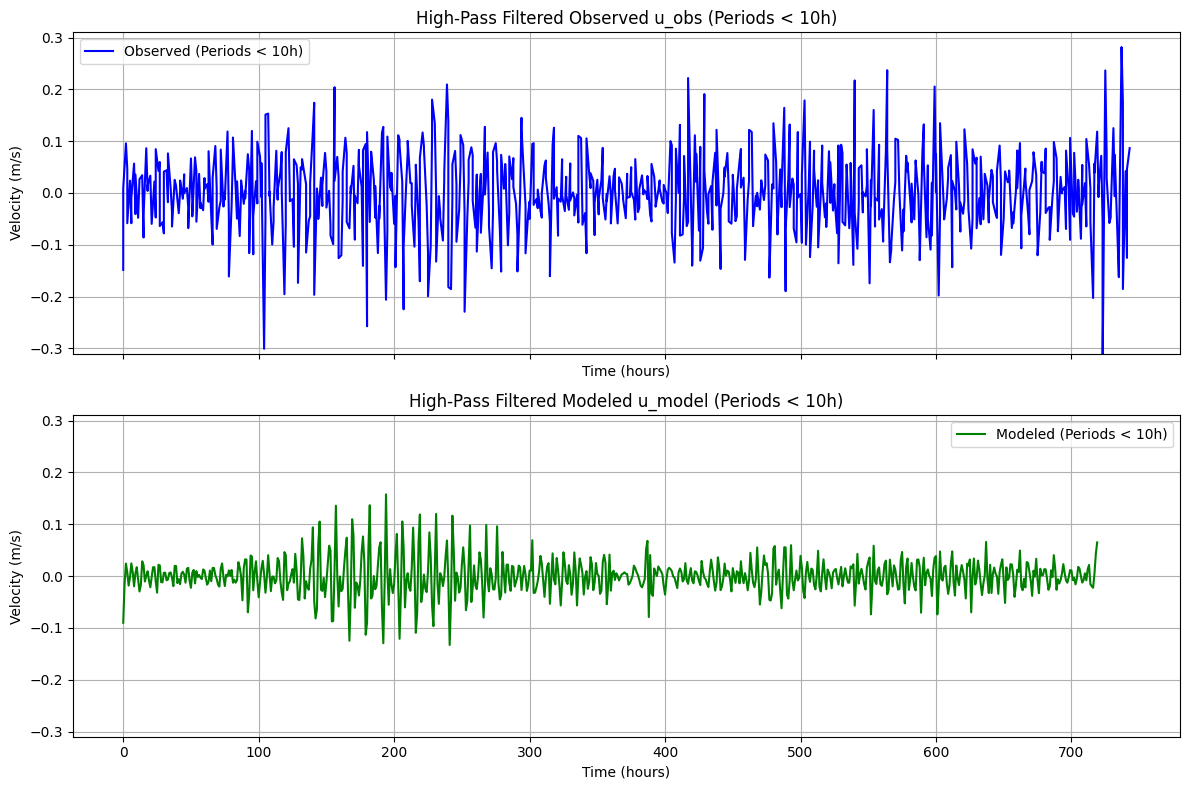

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def highpass_filter(time, signal, cutoff_period=10):
    """Remove frequencies with periods longer than `cutoff_period` hours (high-pass filter)."""

    # Compute FFT
    n = len(signal)
    dt = np.mean(np.diff(time))  # Time step in hours
    freq = np.fft.rfftfreq(n, d=dt)  # Frequency axis (in Hz or cycles per hour)
    spectrum = np.fft.rfft(signal)   # Compute FFT

    # Define cutoff frequency
    cutoff_freq = 1 / cutoff_period  # Frequency corresponding to the longest period to keep

    # Zero out frequencies below the cutoff (i.e., remove long periods)
    spectrum[freq < cutoff_freq] = 0

    # Inverse FFT to reconstruct the high-pass filtered signal
    filtered_signal = np.fft.irfft(spectrum, n=n)

    return filtered_signal

# Apply high-pass filter (removing periods ≥ 10 hours)
u_obs_highpass = highpass_filter(obs_time, u_obs.squeeze().values, cutoff_period=10)
u_model_highpass = highpass_filter(model_time, u_sel.squeeze().values, cutoff_period=10)

# Create figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot high-pass filtered observed signal
axs[0].plot(obs_time, u_obs_highpass, label="Observed (Periods < 10h)", color='b')
axs[0].set_ylabel("Velocity (m/s)")
axs[0].set_title("High-Pass Filtered Observed u_obs (Periods < 10h)")
axs[0].set_ylim(-.31,.31)
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Time (hours)")

# Plot high-pass filtered modeled signal
axs[1].plot(model_time, u_model_highpass, label="Modeled (Periods < 10h)", color='g')
axs[1].set_xlabel("Time (hours)")
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_ylim(-.31,.31)
axs[1].set_title("High-Pass Filtered Modeled u_model (Periods < 10h)")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


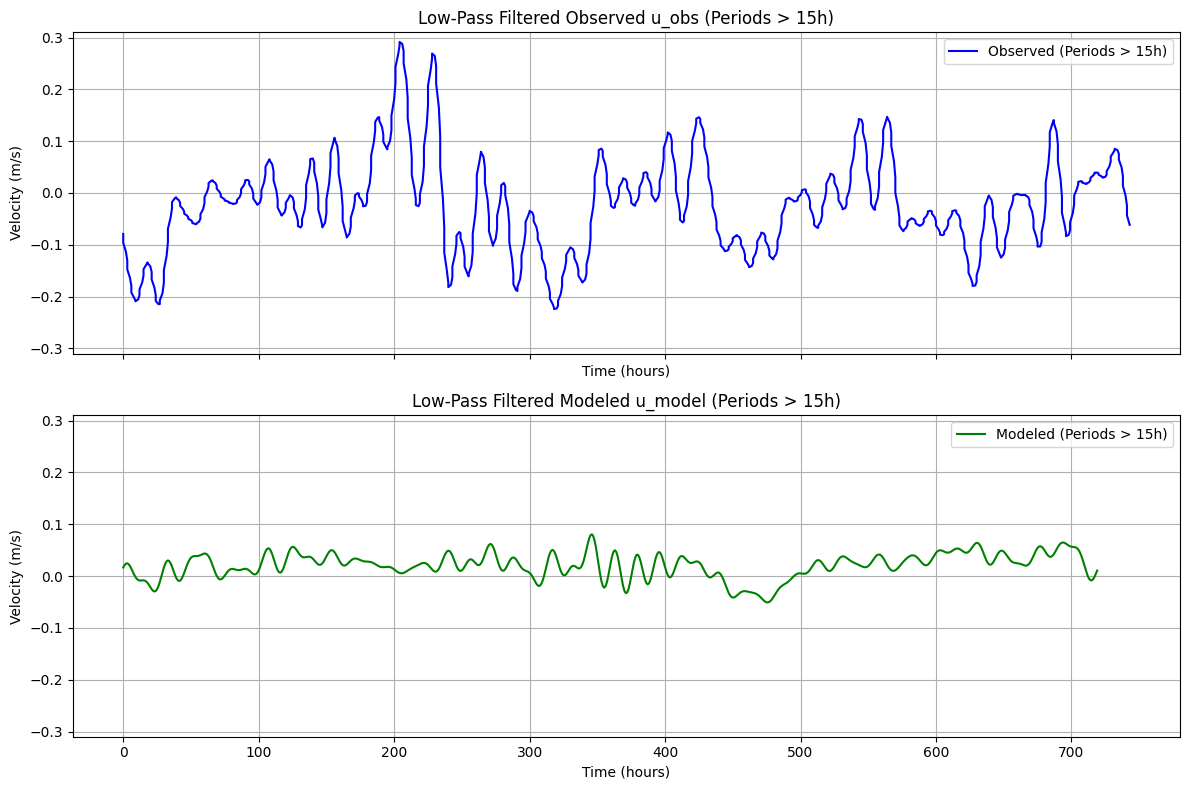

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def lowpass_filter(time, signal, cutoff_period=15):
    """Remove frequencies with periods longer than `cutoff_period` hours (high-pass filter)."""

    # Compute FFT
    n = len(signal)
    dt = np.mean(np.diff(time))  # Time step in hours
    freq = np.fft.rfftfreq(n, d=dt)  # Frequency axis (in Hz or cycles per hour)
    spectrum = np.fft.rfft(signal)   # Compute FFT

    # Define cutoff frequency
    cutoff_freq = 1 / cutoff_period  # Frequency corresponding to the longest period to keep

    # Zero out frequencies below the cutoff (i.e., remove long periods)
    spectrum[freq > cutoff_freq] = 0

    # Inverse FFT to reconstruct the high-pass filtered signal
    filtered_signal = np.fft.irfft(spectrum, n=n)

    return filtered_signal

# Apply high-pass filter (removing periods ≥ 10 hours)
u_obs_lowpass = lowpass_filter(obs_time, u_obs.squeeze().values, cutoff_period=15)
u_model_lowpass = lowpass_filter(model_time, u_sel.squeeze().values, cutoff_period=15)

# Create figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot high-pass filtered observed signal
axs[0].plot(obs_time, u_obs_lowpass, label="Observed (Periods > 15h)", color='b')
axs[0].set_ylabel("Velocity (m/s)")
axs[0].set_title("Low-Pass Filtered Observed u_obs (Periods > 15h)")
axs[0].legend()
axs[0].set_ylim(-.31,.31)
axs[0].grid()
axs[0].set_xlabel("Time (hours)")

# Plot high-pass filtered modeled signal
axs[1].plot(model_time, u_model_lowpass, label="Modeled (Periods > 15h)", color='g')
axs[1].set_xlabel("Time (hours)")
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_ylim(-.31,.31)
axs[1].set_title("Low-Pass Filtered Modeled u_model (Periods > 15h)")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


/tmp/ipykernel_4094838/384995258.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color="red"))


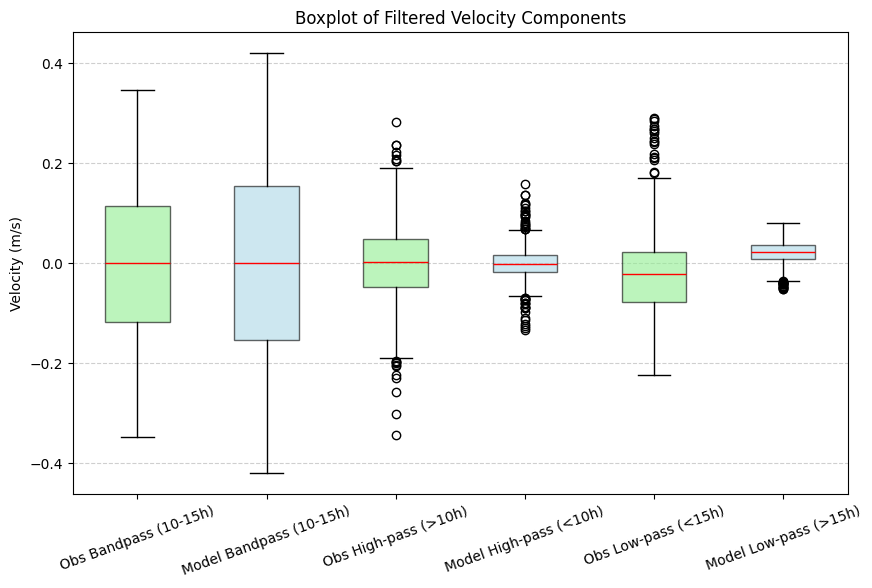

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def bandpass_filter(time, signal, low_cutoff=10, high_cutoff=15):
    """Apply a bandpass filter to retain frequencies between `low_cutoff` and `high_cutoff` hours."""
    n = len(signal)
    dt = np.mean(np.diff(time))
    freq = np.fft.rfftfreq(n, d=dt)
    spectrum = np.fft.rfft(signal)

    # Define cutoff frequencies
    low_freq = 1 / high_cutoff
    high_freq = 1 / low_cutoff

    # Zero out frequencies outside the band
    spectrum[(freq < low_freq) | (freq > high_freq)] = 0

    return np.fft.irfft(spectrum, n=n)

def highpass_filter(time, signal, cutoff_period=10):
    """Remove frequencies with periods longer than `cutoff_period` hours (retain high frequencies)."""
    n = len(signal)
    dt = np.mean(np.diff(time))
    freq = np.fft.rfftfreq(n, d=dt)
    spectrum = np.fft.rfft(signal)

    # Define cutoff frequency
    cutoff_freq = 1 / cutoff_period  

    # Zero out frequencies below the cutoff (remove long periods)
    spectrum[freq < cutoff_freq] = 0

    return np.fft.irfft(spectrum, n=n)

def lowpass_filter(time, signal, cutoff_period=15):
    """Remove frequencies with periods shorter than `cutoff_period` hours (retain low frequencies)."""
    n = len(signal)
    dt = np.mean(np.diff(time))
    freq = np.fft.rfftfreq(n, d=dt)
    spectrum = np.fft.rfft(signal)

    # Define cutoff frequency
    cutoff_freq = 1 / cutoff_period  

    # Zero out frequencies above the cutoff (remove short periods)
    spectrum[freq > cutoff_freq] = 0

    return np.fft.irfft(spectrum, n=n)

# Apply filters to observed and modeled data
u_obs_bandpass = bandpass_filter(obs_time, u_obs.squeeze().values, low_cutoff=10, high_cutoff=15)
u_model_bandpass = bandpass_filter(model_time, u_sel.squeeze().values, low_cutoff=10, high_cutoff=15)

u_obs_highpass = highpass_filter(obs_time, u_obs.squeeze().values, cutoff_period=10)
u_model_highpass = highpass_filter(model_time, u_sel.squeeze().values, cutoff_period=10)

u_obs_lowpass = lowpass_filter(obs_time, u_obs.squeeze().values, cutoff_period=15)
u_model_lowpass = lowpass_filter(model_time, u_sel.squeeze().values, cutoff_period=15)

# Prepare data for boxplot
data = [
    u_obs_bandpass, u_model_bandpass,
    u_obs_highpass, u_model_highpass,
    u_obs_lowpass, u_model_lowpass
]

labels = [
    "Obs Bandpass (10-15h)", "Model Bandpass (10-15h)",
    "Obs High-pass (>10h)", "Model High-pass (<10h)",
    "Obs Low-pass (<15h)", "Model Low-pass (>15h)"
]

# Define colors (Obs = Light Green, Model = Light Blue)
colors = ['lightgreen', 'lightblue', 'lightgreen', 'lightblue', 'lightgreen', 'lightblue']

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = ax.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color="red"))

# Apply colors to boxes
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)  # Transparency for better readability

ax.set_ylabel("Velocity (m/s)")
ax.set_title("Boxplot of Filtered Velocity Components")

plt.xticks(rotation=20)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


In [27]:
import xarray as xr
import numpy as np
target_depth_levels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50]
# Load ROMS output using your pattern
roms_output = ROMSOutput(
    grid=grid,
    path=[
        model_data_path,
    ],
    use_dask=True,
)

ds = roms_output.regrid(var_names=["u", "v"],depth_levels=target_depth_levels)

u_mean=ds['u'].thin({'time': 48}).mean('time').load()
v_mean=ds['v'].thin({'time': 48}).mean('time').load()

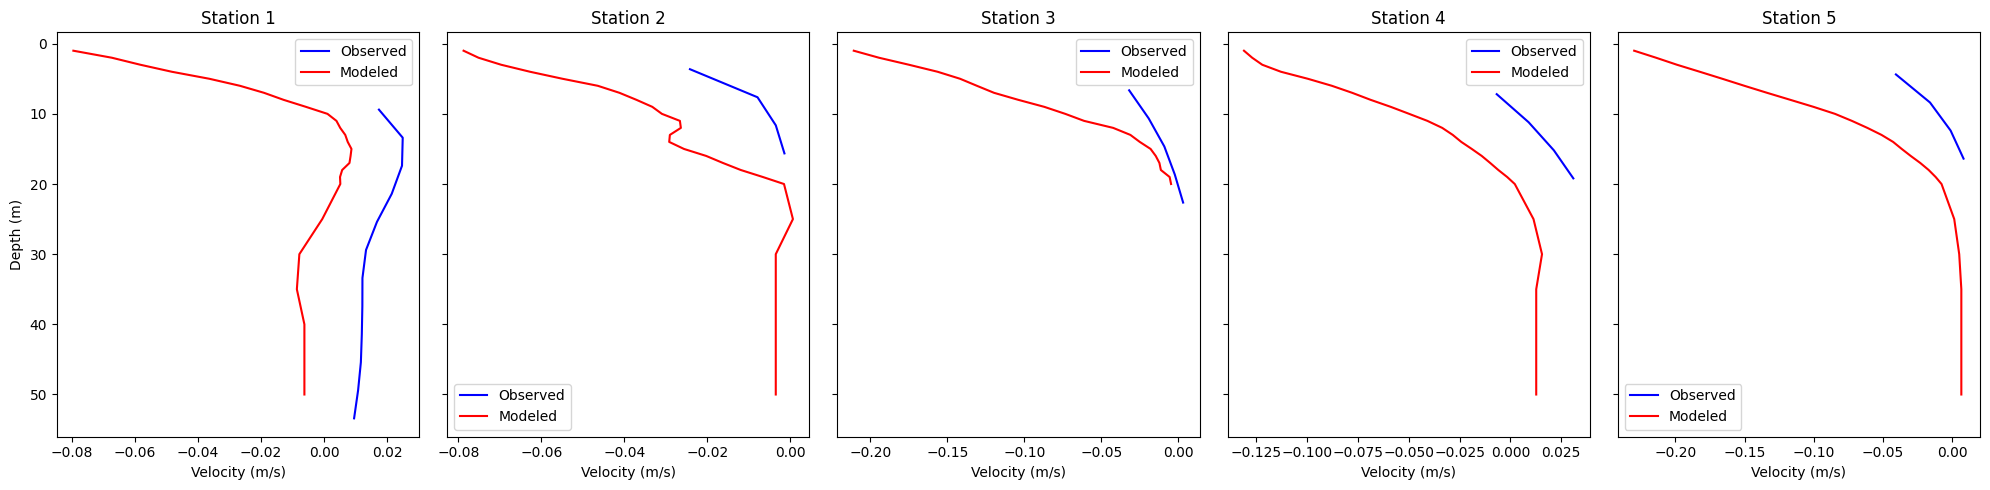

In [28]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

# Loop through each dataset and create a subplot
for i, (key, obs) in enumerate(datasets.items()):
    ax = axes[i]  # Select subplot
    obs=list(datasets.values())[i]
    obs_lon=obs.lon
    obs_lat=obs.lat
    # Plot observed profile
    ax.plot(obs['u'].mean('time_dim').squeeze(), obs.depth, label="Observed", color='b')

    # Extract nearest model data
    u_sel = u_mean.sel(lon=obs_lon.values, method='nearest').sel(lat=obs_lat.values, method='nearest')

    # Plot modeled profile
    ax.plot(u_sel.squeeze(), u_mean.depth, label="Modeled", color='r')

    # Reverse y-axis
    ax.invert_yaxis()

    # Titles and labels
    ax.set_title(f"Station {i+1}")
    if i == 0:
        ax.set_ylabel("Depth (m)")
    ax.set_xlabel("Velocity (m/s)")
    ax.legend()

plt.tight_layout()
plt.show()
